In [251]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap as colormap
from IPython.display import HTML
import math
import os, sys
sys.path.append(os.path.relpath("../src"))
from kitaev_chain import kitaev_chain_model, quench_simulation, U
FFwriter=FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
from utils import intersections, gamma_n,expm, to_n, s0, sx, sy, sz, maj_ordered, tensor_product, canon_eigen, expm, c, zero, LOSCHMIDT_BDG, LOSCHMIDT_TFIM, STATES

In [252]:
gamma_n(4).T.conj() @ np.array([1,2,3,4,1j,2j,3j,4j]) * 2 ** .5


array([ 1.+1.j, -1.-1.j,  2.+2.j, -2.-2.j,  3.+3.j, -3.-3.j,  4.+4.j,
       -4.-4.j])

In [253]:
n = 15
dt = .1
t_steps = 30
T = 300
N = 3 * n
G_D = gamma_n(N).conj().T

In [254]:
zeta = 6
def leg_params(n, k): # n sites, 0 <= |k| <= 1 phase (0 - topological, 1 - trivial), from left to right iff k > 0
    factor = 1 if k >= 0 else -1
    h = 0.5 + np.tanh((np.linspace(-2 * zeta, -zeta, n) + 3 * zeta * np.abs(k))[::factor]) * .5
    J = 0.5 - np.tanh((np.linspace(-2 * zeta, -zeta, n) + 3 * zeta * np.abs(k))[::factor]) * .5
    h = ((0.5 + np.tanh((np.linspace(-2 * zeta, -zeta, n) + 3 * zeta * np.abs(k))[::factor]) * .5) ** 2) * 10
    J = np.ones(n)
    return h , J

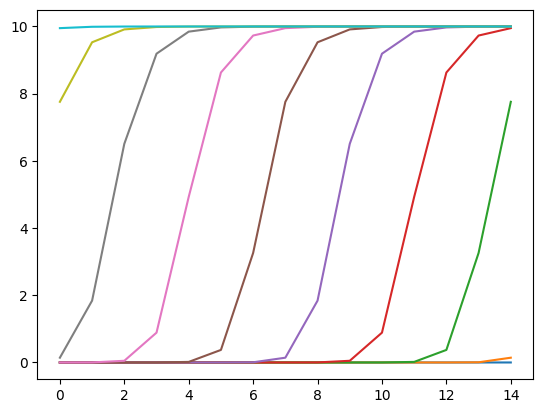

In [255]:
zeta = 3
w = 5
def leg_params(n, k): # n sites, 0 <= |k| <= 1 phase (0 - topological, 1 - trivial), from left to right iff k > 0
    factor = 1 if k >= 0 else -1
    x = (np.linspace(-zeta * w, -zeta, n) + (w + 1) * zeta * np.abs(k))[::factor]
    h = 0.5 + np.tanh(x) * .5
    J = 0.5 - np.tanh(x) * .5
    h = ((0.5 + np.tanh(x) * .5) ** 2) * 10
    J = np.ones(n)
    return h , J

for k in np.linspace(0, 1, 10):
    h, J = leg_params(n, k)
    plt.plot(h)


In [256]:
# Legs are:     0 - left, 1 - down, 2 - right
# Elements are: leg, order == top->triv, reversed
protocol = [
    (0, True),
    (1, False),
    (2, True),
    (0, False),
    (1, True),
    (2, False),
]

def compute_chain_params(step_idx, t):
    k = [0, 1, 0]
    for leg, top_triv in protocol[:step_idx]:
        k[leg] = 1 if top_triv else 0
    if step_idx < len(protocol):
        leg, top_triv = protocol[step_idx]
        k[leg] = t / T
        if not top_triv: k[leg] = 1 - k[leg]
        if True: k[leg] *= -1

    return [leg_params(n, k_) for k_ in k]

def plot_chain_params(ax, chain_params):
    ax.set_xlim( -1.1, 1.1)
    ax.set_ylim( -1.1, 0.1)
    t = np.linspace(0, 1, n + 1)[1:][::-1]
    for leg, (h, J) in enumerate(chain_params):
        ax.scatter(
            x=t * np.cos((leg - 2) * np.pi/2),
            y=t * np.sin((leg - 2) * np.pi/2),
            c='white',
            s=60,
            facecolors=None,
            edgecolors=list(zip(
                np.atan2(J, h) / np.pi * 2, #r
                (1 - np.atan2(J, h) / 2) * .3, #g
                1 - np.atan2(J, h) / 2 #b
            ))
        )
def plot_majorana(ax, state, color):
    state_maj_basis = np.abs(G_D @ state).flatten()
    ax.set_xlim( -1.1, 1.1)
    ax.set_ylim( -1.1, 0.1)
    t = np.linspace(0, 1, 2 * n + 1)[1:][::-1]
    for leg in range(3):
        sites = state_maj_basis[leg * (2 * n) : (leg + 1) * (2 * n)]
        ax.scatter(
            x=t * np.cos((leg - 2) * np.pi/2),
            y=t * np.sin((leg - 2) * np.pi/2),
            c=color,
            s=sites * 80
            )
    ax.scatter(
            x=[0],
            y=[0],
            c=color,
            s=state_maj_basis[-2] * 80
            )

In [257]:
def compute_H_BdG(chain_params):
    H = np.zeros((2 * N, 2 * N))
    for leg, params in enumerate(chain_params):
        h, J = params
        mu = -2 * h
        t = J
        delta = -t
        for i in range(n):
            i_ = i + leg * n
            H[i_][i_] = -mu[i] / 2
            H[i_ + N][i_ + N] = mu[i] / 2
        for i in range(n):
            i_ = i + leg * n
            j = i_ + 1
            if i == n - 1: j = i + ((leg + 1) % 3) * n
            H[i_][j] = H[j][i_] = - t[i] / 2
            H[i_ + N][j + N] = H[j + N][i_ + N] = t[i] / 2
            H[i_][j + N] = H[j + N][i_] = delta[i] / 2
            H[j][i_ + N] = H[i_ + N][j] = - delta[i] / 2
    return H

In [258]:
chain_params = compute_chain_params(0, 0)
H = compute_H_BdG(chain_params)
evals, evecs = canon_eigen(*np.linalg.eigh(H))

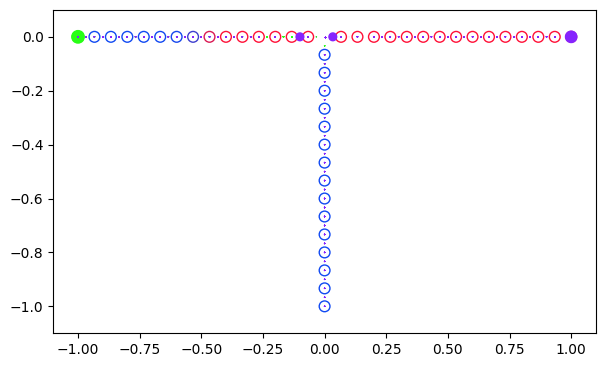

In [259]:
indices = [1, N]
plt.gcf().set_size_inches((7, 4.2))
plot_chain_params(plt.gca(),compute_chain_params(0, 0.5*T))
plot_majorana(plt.gca(), evecs[:,indices[0]], "#28FF14")
plot_majorana(plt.gca(), evecs[:,indices[1]], "#8624FE")

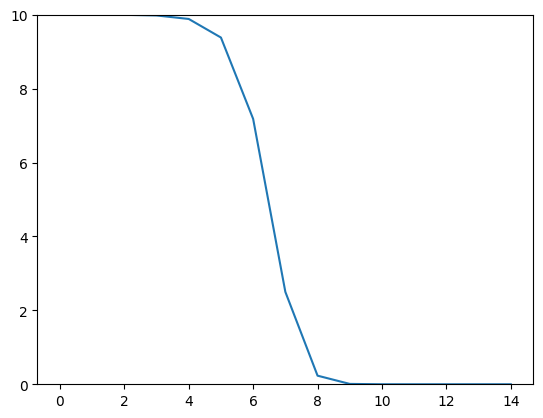

In [260]:
chain_params = compute_chain_params(2, 0.5 * T)
plt.ylim(0, 10)
plt.plot(chain_params[2][0])

In [261]:
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from matplotlib.figure import Figure
import io
from tkinter import filedialog, simpledialog
from PIL import Image

# live-updating matplotlib plot embedded in a Tkinter window

class LiveBDGPlot:
    def __init__(self, master):
        self.master = master
        master.title("Live BdG eigenvalues")

        self.fig = Figure(figsize=(7, 4), dpi=100)
        self.ax = self.fig.add_subplot(111)
        self.canvas = FigureCanvasTkAgg(self.fig, master=master)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

        toolbar = NavigationToolbar2Tk(self.canvas, master)
        toolbar.update()
        toolbar.pack(side=tk.TOP, fill=tk.X)

        ctrl = tk.Frame(master)
        ctrl.pack(side=tk.BOTTOM, fill=tk.X)

        self.start_btn = tk.Button(ctrl, text="Start", command=self.start)
        self.start_btn.pack(side=tk.LEFT, padx=2, pady=2)

        self.stop_btn = tk.Button(ctrl, text="Stop", command=self.stop)
        self.stop_btn.pack(side=tk.LEFT, padx=2, pady=2)

        self.step_btn = tk.Button(ctrl, text="Step", command=self.step)
        self.step_btn.pack(side=tk.LEFT, padx=2, pady=2)

        self.reset_btn = tk.Button(ctrl, text="Reset", command=self.reset)
        self.reset_btn.pack(side=tk.LEFT, padx=2, pady=2)

        self.status = tk.Label(ctrl, text="step 0  t 0.000")
        self.status.pack(side=tk.RIGHT, padx=6)

        # Add a button to the existing GUI (app already exists in the notebook)

        self.export_button = tk.Button(ctrl, text="Export GIF", command=self.export_gif)
        # pack next to existing controls (will appear in the window)
        self.export_button.pack(side=tk.LEFT, padx=2, pady=2)


        chain_params_local = compute_chain_params(0, 0)
        H_local = compute_H_BdG(chain_params_local)
        _, evecs = canon_eigen(*np.linalg.eigh(H_local))
        self.MZMs = evecs[:,indices]
        self.running = False
        self.step_idx = 0
        self.t = 0.0

        # initial draw
        self.draw()

    def draw(self):
        self.ax.clear()
        plot_chain_params(self.ax, compute_chain_params(self.step_idx, self.t))
        plot_majorana(self.ax, self.MZMs[:,0], "#28FF14")
        plot_majorana(self.ax, self.MZMs[:,1], "#8624FE")
        self.ax.set_title(f"Step {self.step_idx}  t={self.t:.3f}")
        self.canvas.draw()
        self.status.config(text=f"step {self.step_idx}  t {self.t:.3f}")

    def update(self):
        if not self.running:
            return
        # advance time and step
        try:
            step_dt = float(dt)
            total_T = float(T)
        except NameError:
            step_dt = 0.1
            total_T = 10.0

        for _ in range(t_steps): 
            self.t += step_dt
            if self.t >= total_T:
                self.t = 0.0
                try:
                    self.step_idx = (self.step_idx + 1) % len(protocol)
                except NameError:
                    self.step_idx += 1
            chain_params_local = compute_chain_params(self.step_idx, self.t)
            H_local = compute_H_BdG(chain_params_local)
            U_local = expm(1j * dt * H_local, 4)
            self.MZMs = U_local @ self.MZMs
        
        self.draw()
        self.master.after(1, self.update)

    def start(self):
        if not self.running:
            self.running = True
            self.update()

    def stop(self):
        self.running = False

    def step(self):
        try:
            step_dt = float(dt)
            total_T = float(T)
        except NameError:
            step_dt = 0.1
            total_T = 10.0

        self.t += step_dt
        if self.t >= total_T:
            self.t = 0.0
            try:
                self.step_idx = (self.step_idx + 1) % len(protocol)
            except NameError:
                self.step_idx += 1
        self.draw()

    def reset(self):
        self.stop()
        self.step_idx = 0
        self.t = 0.0
        self.draw()
    
    def export_gif(self):
        # ask user where to save
        path = filedialog.asksaveasfilename(defaultextension='.gif',
                                            filetypes=[('GIF files', '*.gif')],
                                            title='Export simulation as GIF')
        if not path:
            return

        # ask FPS
        try:
            fps = simpledialog.askinteger("Export GIF", "Frames per second (fps):", initialvalue=10, minvalue=1, maxvalue=60)
            if fps is None:
                fps = 10
        except Exception:
            fps = 10

        # compute total number of "draw" frames to match the live update() logic:
        try:
            draws_per_step = max(1, int(T / (dt * t_steps)))
        except Exception:
            draws_per_step = 100
        total_frames = draws_per_step * len(protocol)

        # prepare initial state (same as class __init__)
        chain_params_local = compute_chain_params(0, 0)
        H_local = compute_H_BdG(chain_params_local)
        _, evecs_local = canon_eigen(*np.linalg.eigh(H_local))
        MZMs_local = evecs_local[:, indices].copy()  # two zero-modes
        step_idx_local = 0
        t_local = 0.0

        # pause running simulation while exporting
        was_running = getattr(self, "running", False)
        self.stop()
        self.status.config(text=f"Exporting GIF: 0/{total_frames}")
        self.master.update()

        import matplotlib.pyplot as _plt
        frames = []
        # create a separate figure for rendering frames
        fig = _plt.figure(figsize=self.fig.get_size_inches(), dpi=self.fig.dpi)
        ax = fig.add_subplot(111)

        try:
            for i in range(total_frames):
                # advance t by t_steps * dt, each inner step updates H and MZMs
                for _ in range(t_steps):
                    t_local += dt
                    if t_local >= T:
                        t_local = 0.0
                        step_idx_local = (step_idx_local + 1) % len(protocol)
                    chain_params_local = compute_chain_params(step_idx_local, t_local)
                    H_local = compute_H_BdG(chain_params_local)
                    U_local = expm(1j * dt * H_local, 4)
                    MZMs_local = U_local @ MZMs_local

                # draw the frame
                ax.clear()
                plot_chain_params(ax, chain_params_local)
                plot_majorana(ax, MZMs_local[:, 0], "#28FF14")
                plot_majorana(ax, MZMs_local[:, 1], "#8624FE")
                ax.set_title(f"Step {step_idx_local}  t={t_local:.3f}")

                # render to an in-memory PNG and convert to PIL image
                buf = io.BytesIO()
                fig.savefig(buf, format='png', bbox_inches='tight')
                buf.seek(0)
                if Image is not None:
                    img = Image.open(buf).convert('RGBA')
                    frames.append(img.copy())
                    img.close()
                else:
                    # If Pillow isn't available, raise a helpful error
                    buf.close()
                    raise RuntimeError("Pillow is required to export GIFs. Install pillow (pip install pillow).")
                buf.close()

                # update status in GUI
                self.status.config(text=f"Exporting GIF: {i+1}/{total_frames}")
                self.master.update()
        finally:
            _plt.close(fig)

        if not frames:
            self.status.config(text="Export cancelled or no frames captured.")
            if was_running:
                self.start()
            return

        # save list of PIL images as an animated GIF
        duration = max(1, int(1000 / fps))  # ms per frame
        try:
            frames[0].save(path, save_all=True, append_images=frames[1:], format='GIF',
                        duration=duration, loop=0, optimize=False)
        except Exception as e:
            self.status.config(text=f"Export failed: {e}")
        else:
            self.status.config(text=f"Exported GIF: {path} ({len(frames)} frames)")

        # resume simulation if it was running
        if was_running:
            self.start()

root = tk.Tk()
app = LiveBDGPlot(root)
root.mainloop()

